# Descriptive Statistics

Notebook with the descriptive statistics of the graph

In [70]:
# Mathematical and Data Managment
import numpy as np
import pandas as pd
from datetime import datetime

# Graph Managment
import graph_tool.all as gt

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# Miscellaneous
from glob import glob
from tqdm import tqdm

In [2]:
def diametros(g: gt.Graph, w = None) -> pd.DataFrame:
    if w==None:
        weights = None
        name = 'Diametro Simple'
    else:
        weights =g.ep[w]
        name = f'Diametro de {w}'
    diametros= []
    for v in g.vertices():
        d = gt.pseudo_diameter(g, source = v, weights = weights)
        diametros.append(d)

    diametros = pd.DataFrame(diametros, columns = [name, 'Edge'])
    return diametros.drop(columns='Edge')

def descriptive(g: gt.Graph, w=None) -> pd.DataFrame:
    # Date
    date = g.ep['Ending date'][g.edges().next()]
    date = datetime.strptime(date, '%Y-%m-%d')
    
    # Edges, Nodes and Dyads
    nodes = g.num_vertices()
    edges = g.num_edges()
    dyads = edges/2
    density = (edges) / (nodes * nodes -1)
    
    # Connected Components 
    SCC, hist = gt.label_components(g, directed=True)
    WCC, hist = gt.label_components(g, directed=False)
    
    N_SCC = len(set(SCC.a))
    N_WCC = len(set(WCC.a))
    
    # Diameter simple
    diametros_df = diametros(g)
    diametro_simple = float(diametros_df.max(axis=0).iloc[0])
        
    results = {
        'Graph Date': date,
        'Nodes': nodes,
        'Edges': edges,
        'Dyads': dyads,
        'Density': density,
        'Strongly Connected Components': N_SCC,
        'Weakly Connected Components': N_WCC,
        'Diametro Simple': diametro_simple
    }
    
    # Diametro con pesos
    if w is not None:
        diametros_w = diametros(g,w)
        diametro = float(diametros_w.max(axis=0).iloc[0])
        tipo_de_diametro = diametro.max(axis=0).index[0]
        
        results[tipo_de_diametro] = diametro
    
    df = pd.DataFrame([results]).set_index('Graph Date')
        
    return df

## Retweet network with a 3-day rolling window

In [7]:
files_3day = glob('/mnt/disk2/Data/3_Day_Graphs/Graphs/*.graphml')
files_daily = glob('/mnt/disk2/Data/Daily_graphs/Graphs/*.graphml')

ls = []
for file in tqdm(files_3day):
    # Get date
    date = file.split('/')[-1].split('.')[0].split('_')[-1]
    date = datetime.strptime(date, '%Y-%m-%d')
    g = gt.load_graph(file)
    
    # Get Node Degrees Average
    for stat in ['in', 'out', 'total']: 
        vertex_average = gt.vertex_average(g, stat)
        row = [vertex_average[0], vertex_average[1], date, f'Average Degree {stat}']
        ls.append(row)
        
    # Get Edge Propety Average
    for stat in dict(g.ep).items():
        try:
            edge_average = gt.edge_average(g, stat[1])
            row = [edge_average[0], edge_average[1], date, stat[0]]
            ls.append(row)
        except:
            pass
    
    # Clustering and transitivity
    cluester_coef = gt.global_clustering(g,weight = g.ep['Normal Weight'])
    row = [cluester_coef[0], cluester_coef[1], date, 'Global Clustering Coefficient']
    ls.append(row)
    
    transitivity = gt.global_clustering(g)
    row = [transitivity[0], transitivity[1], date, 'Transitivity']
    ls.append(row)

# Get Visualization
viz_3_day = pd.DataFrame(ls, columns=['Value','SE','Date', 'Statistic'])

# Get Confidence Interval
viz_3_day['Lower 5%'] = viz_3_day['Value'] - 1.96*viz_3_day['SE']
viz_3_day['Upper 5%'] = viz_3_day['Value'] + 1.96*viz_3_day['SE']
viz_3_day = viz_3_day.set_index('Date')
viz_3_day = viz_3_day.sort_index()
viz_3_day

100%|██████████| 61/61 [02:38<00:00,  2.60s/it]


,Value,SE,Statistic,Lower 5%,Upper 5%
Date,,,,,
2021-04-28,0.060892,0.000182,Normal Weight,0.060535,0.061250
2021-04-28,1.750345,0.003990,Number of rts,1.742524,1.758165
2021-04-28,25.237907,0.656766,Average Degree total,23.950646,26.525169
2021-04-28,12.618954,0.134036,Average Degree out,12.356244,12.881664
2021-04-28,12.618954,0.637248,Average Degree in,11.369947,13.867960
...,...,...,...,...,...
2021-06-27,11.956282,0.319864,Average Degree total,11.329348,12.583216
2021-06-27,5.978141,0.074208,Average Degree out,5.832694,6.123588
2021-06-27,5.978141,0.307320,Average Degree in,5.375793,6.580489


In [30]:
viz_daily.loc['2021-06-11']

,Value,SE,Statistic,Lower 5%,Upper 5%
Date,,,,,
2021-06-11,0.002021,0.000364,Global Clustering Coefficient,0.001308,0.002734
2021-06-11,0.010509,0.001202,Transitivity,0.008154,0.012864
2021-06-11,3.030029,0.187950,Average Degree in,2.661646,3.398412
2021-06-11,3.030029,0.041918,Average Degree out,2.947870,3.112188
2021-06-11,6.060058,0.193869,Average Degree total,5.680074,6.440042
2021-06-11,0.157149,0.000701,Normal Weight,0.155775,0.158523
2021-06-11,1.316628,0.004201,Number of rts,1.308394,1.324863


In [66]:
ls = []
for file in tqdm(files_daily):
    # Get date
    date = file.split('/')[-1].split('.')[0].split('_')[-1]
    date = datetime.strptime(date, '%Y-%m-%d')
    g = gt.load_graph(file)
    
    # Get Node Degrees Average
    for stat in ['in', 'out', 'total']: 
        vertex_average = gt.vertex_average(g, stat)
        row = [vertex_average[0], vertex_average[1], date, f'Average Degree {stat}']
        ls.append(row)
        
    # Get Edge Propety Average
    for stat in dict(g.ep).items():
        try:
            edge_average = gt.edge_average(g, stat[1])
            row = [edge_average[0], edge_average[1], date, stat[0]]
            ls.append(row)
        except:
            pass
    
    # Clustering and transitivity
    cluester_coef = gt.global_clustering(g,weight = g.ep['Normal Weight'])
    row = [cluester_coef[0], cluester_coef[1], date, 'Global Clustering Coefficient']
    ls.append(row)
    
    transitivity = gt.global_clustering(g)
    row = [transitivity[0], transitivity[1], date, 'Transitivity']
    ls.append(row)
    
    # Number of Edges and Nodes, Dyads and Density
    nodes = g.num_vertices()
    isolate = g.vp['Isolate'].a.sum()
    edges = g.num_edges()
    dyads = edges/2
    density = (edges * 2) / (nodes * nodes -1)
    
    ls.append([nodes-isolate, np.nan, date, 'Non isolate Nodes'])
    ls.append([isolate, np.nan, date, 'Isolate Nodes'])
    ls.append([edges, np.nan, date, 'Number of Edges'])
    ls.append([dyads, np.nan, date, 'Number of Dyads'])
    ls.append([density, np.nan, date, 'Number of Density'])
    
    # Connected Components 
    SCC, _ = gt.label_components(g, directed=True)
    WCC, _ = gt.label_components(g, directed=False)
    
    N_SCC = len(set(SCC.a))
    N_WCC = len(set(WCC.a))
    
    ls.append([N_SCC, np.nan, date, 'Strongly Connected Components'])
    ls.append([N_WCC, np.nan, date, 'Weakly Connected Components'])

# Get Visualization
viz_daily = pd.DataFrame(ls, columns=['Value','SE','Date', 'Statistic'])
viz_daily = viz_daily.astype({
    'Value': 'double',
    'SE':'double'
})

# Get Confidence Interval
viz_daily['Lower 5%'] = viz_daily['Value'] - 1.96*viz_daily['SE']
viz_daily['Upper 5%'] = viz_daily['Value'] + 1.96*viz_daily['SE']
viz_daily = viz_daily.set_index('Date')
viz_daily = viz_daily.sort_index()
viz_daily

100%|██████████| 63/63 [01:25<00:00,  1.36s/it]


,Value,SE,Statistic,Lower 5%,Upper 5%
Date,,,,,
2021-04-28,99093.500000,NaN,Number of Dyads,NaN,NaN
2021-04-28,5.361622,0.066308,Average Degree out,5.231658,5.491586
2021-04-28,10.723244,0.316639,Average Degree total,10.102631,11.343857
2021-04-28,0.112071,0.000423,Normal Weight,0.111242,0.112899
2021-04-28,1.434277,0.003643,Number of rts,1.427136,1.441417
...,...,...,...,...,...
2021-06-29,17555.000000,NaN,Isolate Nodes,NaN,NaN
2021-06-29,101121.000000,NaN,Number of Edges,NaN,NaN
2021-06-29,50560.500000,NaN,Number of Dyads,NaN,NaN


In [67]:
viz_daily.loc['2021-06-02']

,Value,SE,Statistic,Lower 5%,Upper 5%
Date,,,,,
2021-06-02,3.942512,0.252758,Average Degree in,3.447107,4.437916
2021-06-02,3.942512,0.050590,Average Degree out,3.843354,4.041669
2021-06-02,7.885023,0.259417,Average Degree total,7.376566,8.393481
2021-06-02,15612.000000,NaN,Weakly Connected Components,NaN,NaN
2021-06-02,34890.000000,NaN,Strongly Connected Components,NaN,NaN
2021-06-02,0.000213,NaN,Number of Density,NaN,NaN
2021-06-02,145731.000000,NaN,Number of Edges,NaN,NaN
2021-06-02,15429.000000,NaN,Isolate Nodes,NaN,NaN
2021-06-02,72865.500000,NaN,Number of Dyads,NaN,NaN


In [68]:
plt.rcParams['font.family'] = 'cmr10'
plt.rcParams['mathtext.fontset'] = 'cm'

/tmp/ipykernel_2642414/1921796861.py:6: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(12,5))


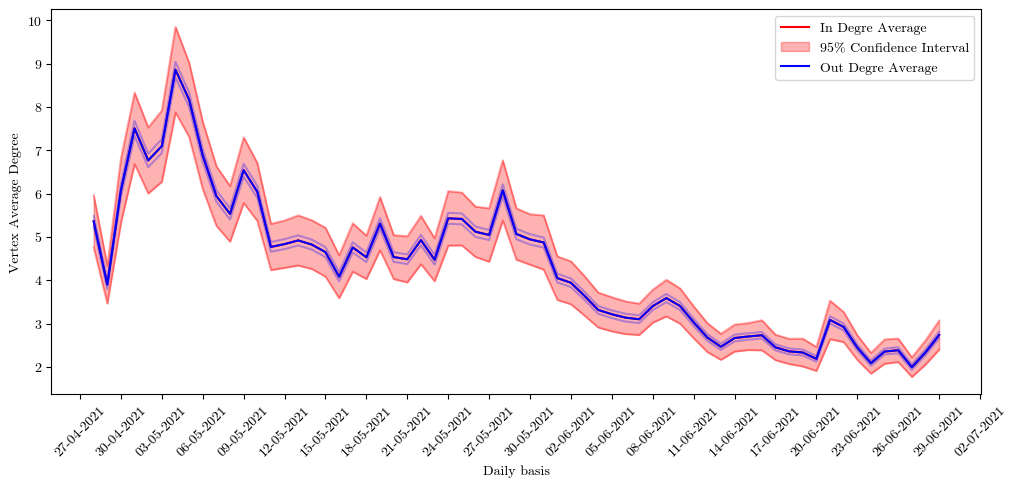

In [75]:
# Separate Types
in_deg = viz_daily[viz_daily['Statistic'] == 'Average Degree in']
out_deg = viz_daily[viz_daily['Statistic'] == 'Average Degree out']

# GRAAAAAPH
fig, ax = plt.subplots(figsize=(12,5))

# In Graph
sns.lineplot(data=in_deg, x=in_deg.index, y='Value', color='red', ax=ax, label='In Degre Average')
sns.lineplot(data=in_deg, x=in_deg.index, y='Lower 5%', color='red', ax=ax, alpha=0.3, label='_nolegend_')
sns.lineplot(data=in_deg, x=in_deg.index, y='Upper 5%', color='red', ax=ax, alpha=0.3, label='_nolegend_')

plt.fill_between(in_deg.index, in_deg['Lower 5%'], in_deg['Upper 5%'], color='red', alpha=0.3, label='95% Confidence Interval')

# Out Graph
sns.lineplot(data=out_deg, x=out_deg.index, y='Value', color='blue', ax=ax, label='Out Degre Average')
sns.lineplot(data=out_deg, x=out_deg.index, y='Lower 5%', color='blue', ax=ax, alpha=0.3, label='_nolegend_')
sns.lineplot(data=out_deg, x=out_deg.index, y='Upper 5%', color='blue', ax=ax, alpha=0.3, label='_nolegend_')

#plt.fill_between(out_deg.index, out_deg['Lower 5%'], out_deg['Upper 5%'], color='blue', alpha=0.3, label='95% Confidence Interval')

# Labels
ax.set_xlabel('Daily basis')
ax.set_ylabel('Vertex Average Degree')
ax.tick_params(axis = 'x',rotation=45)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.legend(bbox_to_anchor=(1, 1), loc='best')
fig.savefig("../Results/average_degree_daily.png", dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_2642414/302999129.py:6: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1,2,figsize=(12, 5))


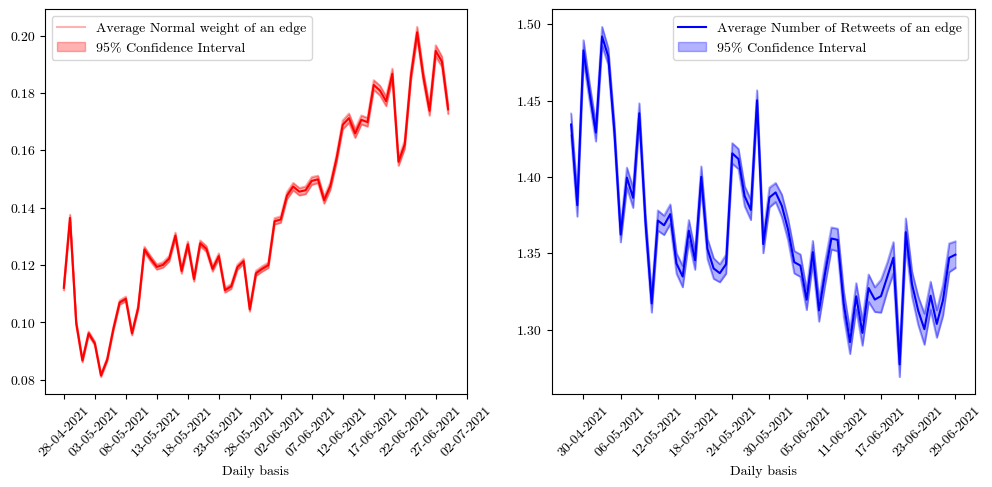

In [93]:
# Separate Types
normal = viz_daily[viz_daily['Statistic'] == 'Normal Weight']
number = viz_daily[viz_daily['Statistic'] == 'Number of rts']

# GRAAAAAPH
fig, ax = plt.subplots(1,2,figsize=(12, 5))

# In Graph
sns.lineplot(data=normal, x=normal.index, y='Value', color='red', ax=ax[0], label='_nolegend')
sns.lineplot(data=normal, x=normal.index, y='Lower 5%', color='red', ax=ax[0], alpha=0.3, label='Average Normal weight of an edge')
sns.lineplot(data=normal, x=normal.index, y='Upper 5%', color='red', ax=ax[0], alpha=0.3, label='_nolegend_')

ax[0].fill_between(normal.index, normal['Lower 5%'], normal['Upper 5%'], color='red', alpha=0.3, label='95% Confidence Interval')
ax[0].set_xlabel('Daily basis')
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_ylabel('')
ax[0].legend()

ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))

# Out Graph
sns.lineplot(data=number, x=number.index, y='Value', color='blue', ax=ax[1], label='Average Number of Retweets of an edge')
sns.lineplot(data=number, x=number.index, y='Lower 5%', color='blue', ax=ax[1], alpha=0.3, label='_nolegend_')
sns.lineplot(data=number, x=number.index, y='Upper 5%', color='blue', ax=ax[1], alpha=0.3, label='_nolegend_')

ax[1].fill_between(number.index, number['Lower 5%'], number['Upper 5%'], color='blue', alpha=0.3, label='95% Confidence Interval')

ax[1].xaxis.set_major_locator(mdates.DayLocator(interval=6))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax[1].set_xlabel('Daily basis')
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_ylabel('')
ax[1].legend()

/tmp/ipykernel_2642414/551260498.py:6: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1,2,figsize=(12, 5))


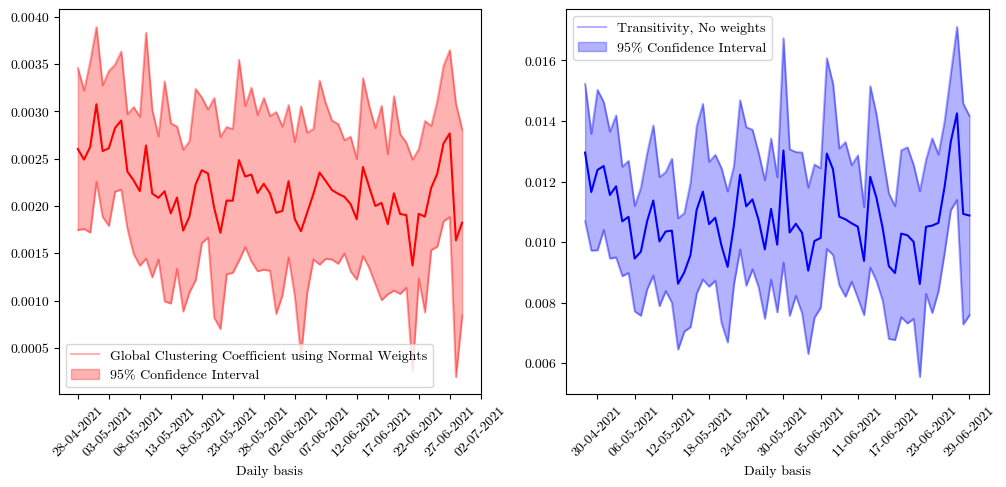

In [95]:
# Separate Types
clust = viz_daily[viz_daily['Statistic'] == 'Global Clustering Coefficient']
transit = viz_daily[viz_daily['Statistic'] == 'Transitivity']

# GRAAAAAPH
fig, ax = plt.subplots(1,2,figsize=(12, 5))

# In Graph
sns.lineplot(data=clust, x=clust.index, y='Value', color='red', ax=ax[0], label='_nolegend')
sns.lineplot(data=clust, x=clust.index, y='Lower 5%', color='red', ax=ax[0], alpha=0.3, label='Global Clustering Coefficient using Normal Weights')
sns.lineplot(data=clust, x=clust.index, y='Upper 5%', color='red', ax=ax[0], alpha=0.3, label='_nolegend_')

ax[0].fill_between(clust.index, clust['Lower 5%'], clust['Upper 5%'], color='red', alpha=0.3, label='95% Confidence Interval')
ax[0].set_xlabel('Daily basis')
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_ylabel('')
ax[0].legend()

ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
# Out Graph
sns.lineplot(data=transit, x=transit.index, y='Value', color='blue', ax=ax[1], label='_nolegend_')
sns.lineplot(data=transit, x=transit.index, y='Lower 5%', color='blue', ax=ax[1], alpha=0.3, label='Transitivity, No weights')
sns.lineplot(data=transit, x=transit.index, y='Upper 5%', color='blue', ax=ax[1], alpha=0.3, label='_nolegend_')

ax[1].fill_between(transit.index, transit['Lower 5%'], transit['Upper 5%'], color='blue', alpha=0.3, label='95% Confidence Interval')

ax[1].xaxis.set_major_locator(mdates.DayLocator(interval=6))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax[1].set_xlabel('Daily basis')
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_ylabel('')
ax[1].legend()

In [96]:
viz_daily['Statistic'].unique()

array(['Number of Dyads', 'Average Degree out', 'Average Degree total',
       'Normal Weight', 'Number of rts', 'Global Clustering Coefficient',
       'Transitivity', 'Average Degree in', 'Non isolate Nodes',
       'Number of Edges', 'Number of Density',
       'Strongly Connected Components', 'Weakly Connected Components',
       'Isolate Nodes'], dtype=object)

/tmp/ipykernel_2642414/1087650048.py:6: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(12, 5))


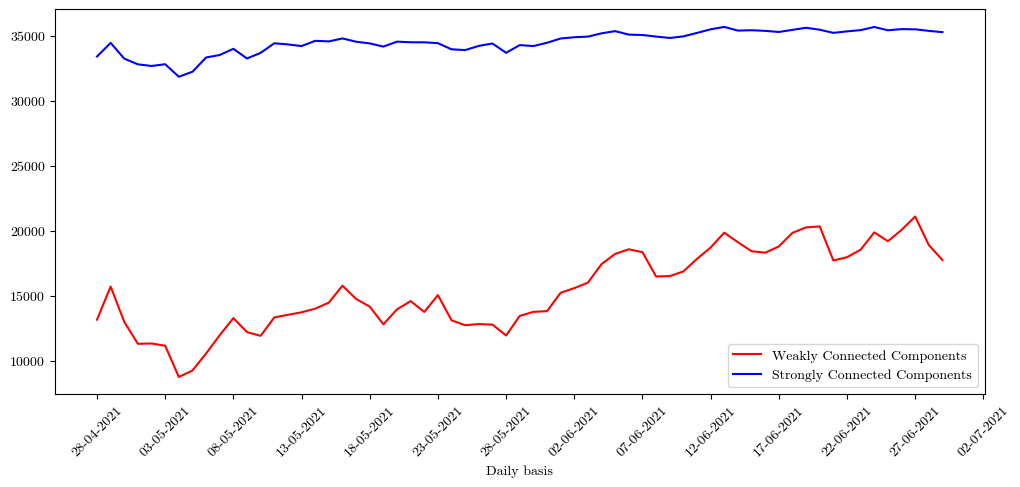

In [102]:
# Separate Types
wcc_df = viz_daily[viz_daily['Statistic'] == 'Weakly Connected Components']
scc_df = viz_daily[viz_daily['Statistic'] == 'Strongly Connected Components']

# GRAAAAAPH
fig, ax = plt.subplots(figsize=(12, 5))

# In Graph
sns.lineplot(data=wcc_df, x=wcc_df.index, y='Value', color='red', ax=ax, label='Weakly Connected Components')
sns.lineplot(data=scc_df, x=scc_df.index, y='Value', color='blue', ax=ax, label='Strongly Connected Components')

ax.set_xlabel('Daily basis')
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))

ax.legend()

In [111]:
viz_daily.loc['2021-04-28']

,Value,SE,Statistic,Lower 5%,Upper 5%
Date,,,,,
2021-04-28,99093.500000,NaN,Number of Dyads,NaN,NaN
2021-04-28,5.361622,0.066308,Average Degree out,5.231658,5.491586
2021-04-28,10.723244,0.316639,Average Degree total,10.102631,11.343857
2021-04-28,0.112071,0.000423,Normal Weight,0.111242,0.112899
2021-04-28,1.434277,0.003643,Number of rts,1.427136,1.441417
2021-04-28,0.002603,0.000437,Global Clustering Coefficient,0.001746,0.003460
2021-04-28,0.012956,0.001156,Transitivity,0.010691,0.015221
2021-04-28,5.361622,0.306879,Average Degree in,4.760138,5.963106
2021-04-28,23934.000000,NaN,Non isolate Nodes,NaN,NaN


/tmp/ipykernel_2642414/2448952510.py:4: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(12, 5))


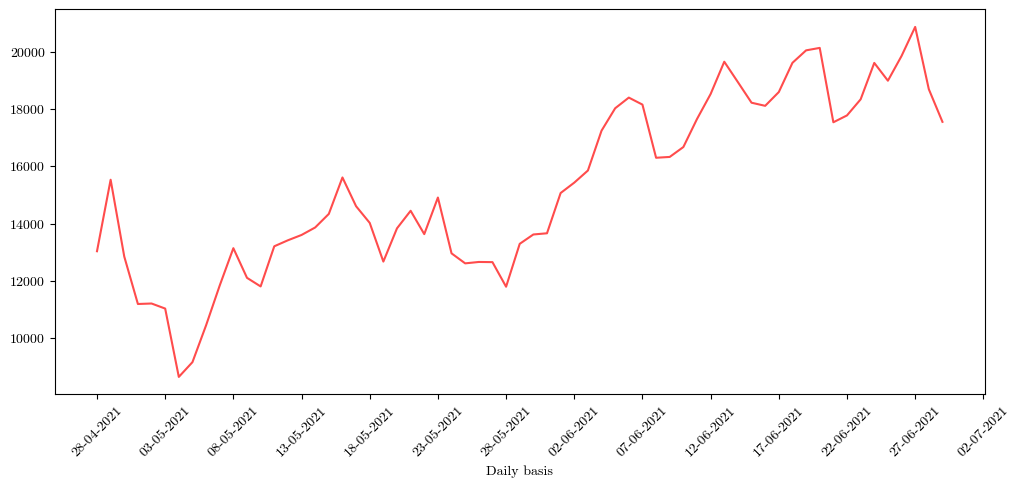

In [169]:
# Isolated Nodes

isolate = viz_daily[viz_daily['Statistic'] == 'Isolate Nodes']
fig, ax = plt.subplots(figsize=(12, 5))

# In Graph
sns.lineplot(data=isolate, x=isolate.index, y='Value', color='red', ax=ax, label='_no_legend', alpha = 0.7)

ax.set_xlabel('Daily basis')
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))

/tmp/ipykernel_2642414/2946771956.py:4: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(12, 5))


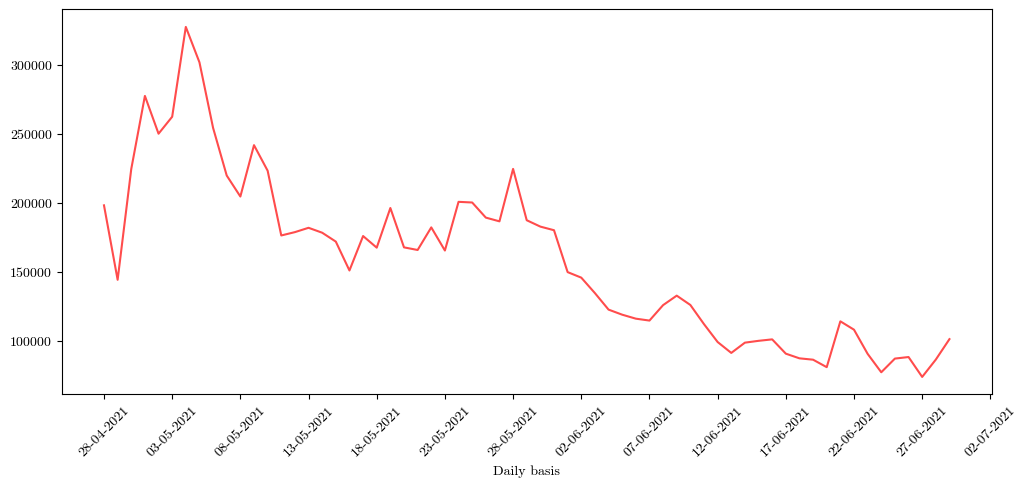

In [170]:
# Number of Edges
edges_df = viz_daily[viz_daily['Statistic'] == 'Number of Edges']
fig, ax = plt.subplots(figsize=(12, 5))

# In Graph
sns.lineplot(data=edges_df, x=edges_df.index, y='Value', color='red', ax=ax, label='_no_legend', alpha = 0.7)

ax.set_xlabel('Daily basis')
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))

In [173]:
viz_daily['Statistic'].unique()

array(['Number of Dyads', 'Average Degree out', 'Average Degree total',
       'Normal Weight', 'Number of rts', 'Global Clustering Coefficient',
       'Transitivity', 'Average Degree in', 'Non isolate Nodes',
       'Number of Edges', 'Number of Density',
       'Strongly Connected Components', 'Weakly Connected Components',
       'Isolate Nodes'], dtype=object)

/tmp/ipykernel_2642414/1756777015.py:3: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(12, 5))


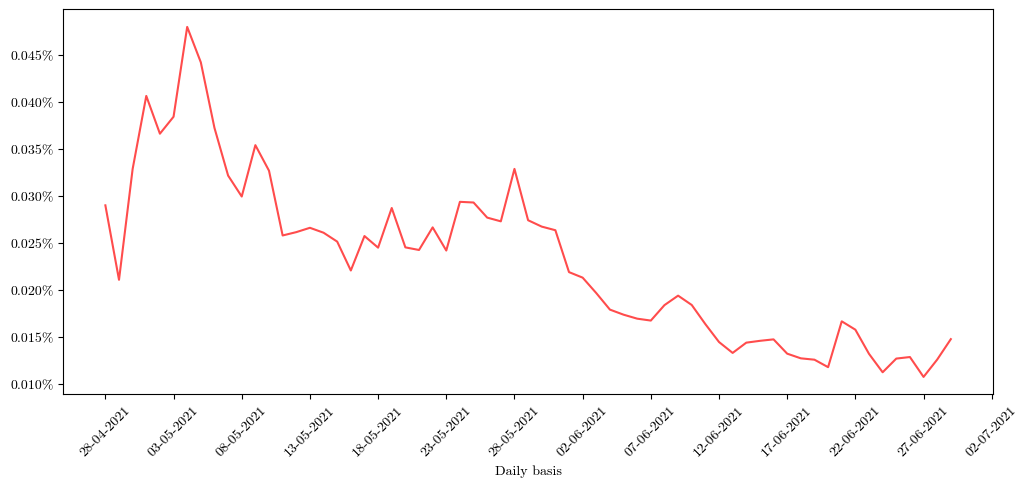

In [178]:
# Number of Edges
den = viz_daily[viz_daily['Statistic'] == 'Number of Density']
fig, ax = plt.subplots(figsize=(12, 5))
percentage_formatter = FuncFormatter(lambda x, pos: f'{x*100:.3f}%')
# In Graph
sns.lineplot(data=den, x=den.index, y='Value', color='red', ax=ax, label='_no_legend', alpha = 0.7)

ax.set_xlabel('Daily basis')
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

## Daily retweet network (with no rolling window)

In [4]:
files = glob('/mnt/disk2/Data/Daily_graphs/*.graphml')
files.sort()

- **Average Degree:** is simply the average number of edges per node in the graph.
$$Average Degree = \frac{Total Edges}{Total Nodes}=\frac{m}{n}$$

In [122]:
descriptive_statistics = dict()

for file in tqdm(files):
    # Get date
    date = file.split('/')[-1].split('.')[0]
    g = gt.load_graph(file)

    # Extract degrees (# PREGUNTAR ESTA INTERPRETACIÓN)

    # Number of links per node
    total_degree = g.degree_property_map("total").a
    total_degree = np.array(total_degree)

    # Number of retweets made by -i from i
    in_degree = g.degree_property_map("in").a
    in_degree = np.array(in_degree)

    # Number of retweets made by i from -i
    out_degree = g.degree_property_map("out").a
    out_degree = np.array(out_degree)

    # Number of edges
    n_edges = g.num_edges()

    # Nomber of nodes
    n_nodes = g.num_vertices()

    # Get Assortativity
    assortativity = gt.assortativity(g, deg = g.vp['Label'])

    descriptive_statistics[date] = {
        "n_nodes": n_nodes,
        "n_edges": n_edges,
        "total_degree": total_degree,
        "in_degree": in_degree,
        "out_degree": out_degree,
        "assortativity_mean": assortativity[0],
        "assortativity_variance": assortativity[1]
    }

100%|██████████| 63/63 [00:39<00:00,  1.58it/s]


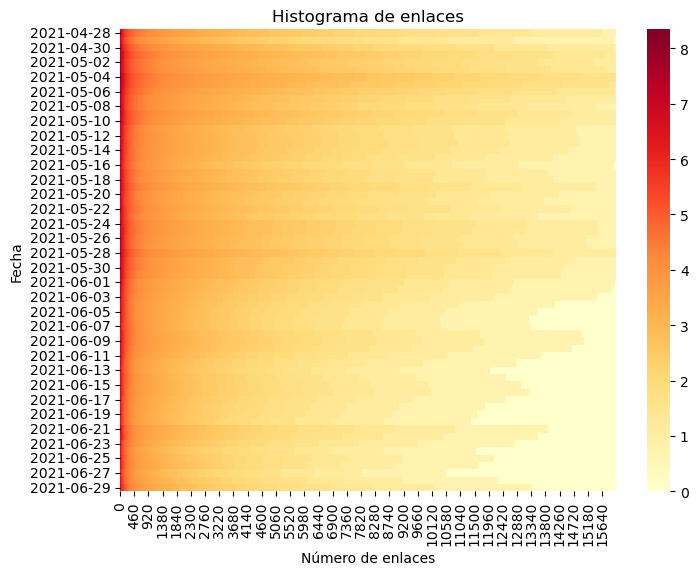

In [43]:
min_n_nodes = min([descriptive_statistics[d]["n_nodes"] for d in descriptive_statistics.keys()])

# Ordenamos de mayor cantidad de enlaces a menor y creamos un vector para extraer a los min_n_nodes usuarios con mas enlaces.
# Luego vamos a crear un dataframe con la historia de como evoluciona la cantidad de enlaces en el tiempo
history_total_degree = pd.concat([pd.DataFrame(np.sort(descriptive_statistics[d]["total_degree"])[::-1][0:min_n_nodes]).T for d in descriptive_statistics.keys()])
history_total_degree.index = [i for i in descriptive_statistics.keys()]

fig, ax = plt.subplots(figsize = (8, 6))
plt.title("Histograma de enlaces")
sns.heatmap(np.log(history_total_degree), ax = ax, cmap = "YlOrRd")
plt.xlabel("Número de enlaces");
plt.ylabel("Fecha");

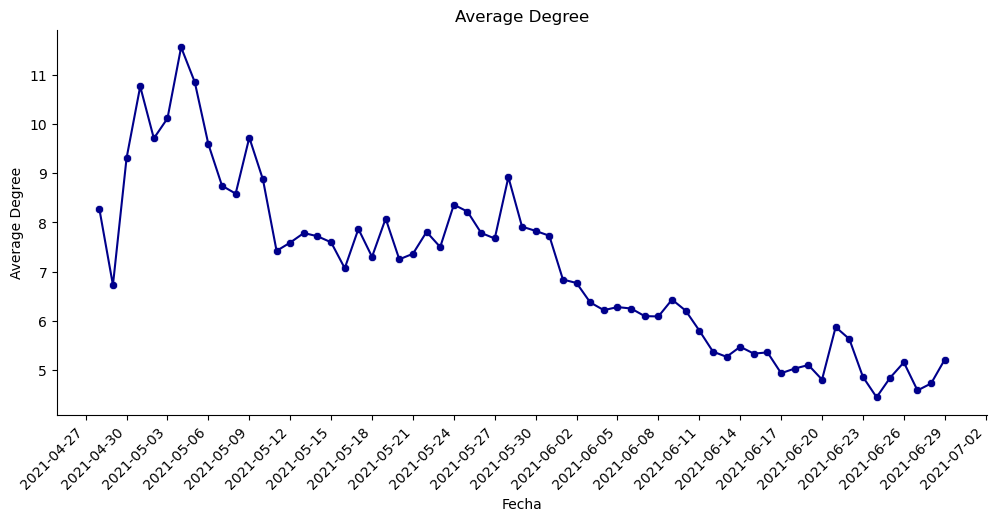

In [123]:
import matplotlib.dates as mdates
av_degree = pd.concat([pd.DataFrame({"Fecha": d, "Average Degree": descriptive_statistics[d]["n_edges"]/descriptive_statistics[d]["n_nodes"]}, index = [0]) for d in descriptive_statistics.keys()])
av_degree["Fecha"] = pd.to_datetime(av_degree["Fecha"])

fig, ax = plt.subplots(figsize = (12, 5))
sns.despine()
plt.title("Average Degree")
sns.lineplot(data = av_degree, x = "Fecha", y = "Average Degree", ax = ax, color = "darkblue")
sns.scatterplot(data = av_degree, x = "Fecha", y = "Average Degree", ax = ax, color = "darkblue")
plt.xlabel("Fecha");
plt.xticks(rotation = 45, ha = 'right');
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))

- **Assortativity:** is a preference for a network's nodes to attach to others that are similar in some way. Though the specific measure of similarity may vary, network theorists often examine assortativity in terms of a node's degree.

    The **assortativity coefficient** is the Pearson correlation coefficient of degree between pairs of linked nodes. Positive values of `r` indicate a correlation between nodes of similar degree, while negative values indicate relationships between nodes of different degree. In general, `r` lies between `−1` and `1`. When `r = 1`, the network is said to have perfect assortative mixing patterns, when `r = 0` the network is non-assortative, while at `r = −1` the network is completely disassortative.

    The *assortativity coefficient* is given by 

    $$
    r = \frac{\sum_{jk}{jk (e_{jk} - q_j q_k)}}{\sigma_{q}^{2}}
    $$

    In this equation:

    - $ \sum_{jk} $ denotes the summation over all degrees $ j $ and $ k $ in the network.
    - $ jk $ represents the product of degrees $ j $ and $ k $.
    - $ e_{jk} $ is the joint probability distribution of the remaining degrees of two connected vertices. In an undirected graph, this is symmetric and must satisfy the sum rules:
        - $ \sum_{jk}{e_{jk}} = 1 $, ensuring that the total probability is 1.
        - $ \sum_{j}{e_{jk}} = q_{k} $, linking it to the distribution of the remaining degree.
    - $ q_j $ and $ q_k $ are the distributions of the remaining degree for vertices of degrees $ j $ and $ k $, respectively. 
    - $ \sigma_{q}^{2} $ is the variance of the distribution of the remaining degree.

    The term $ q_{k} $ represents the distribution of the *remaining degree*, which captures the number of edges leaving a node, excluding the edge that connects the pair in question. This distribution is derived from the degree distribution $ p_{k} $ as follows:

    $$
    q_{k} = \frac{(k+1)p_{k+1}}{\sum_{j \geq 1} j p_j}
    $$

    - Here, $ p_{k} $ is the degree distribution of the network, and $ p_{k+1} $ refers to the probability of a node having $ k+1 $ connections.


- **Categorical Assortativity (assortativity by attribute):** is a measure used to determine how often nodes with a certain categorical attribute, like color or type, connect to other nodes with the same attribute. It is given by:

    $$
    r = \frac{\sum_{ij}{e_{ij} - q_i q_j}}{\sum_{i}{q_i q_i} - \sum_{i}{q_i q_j}}
    $$

    Where:

    - $ e_{ij} $ is the proportion of edges in the network that connect nodes of type $ i $ to nodes of type $ j $.
    - $ q_i $ and $ q_j $ are the proportions of each type of node (type $ i $ and $ j $, respectively) at the ends of a randomly chosen edge.

    In this context:

    - A positive value of $ r $ indicates assortative mixing, where nodes tend to connect to others that are similar.
    - A negative value of $ r $ indicates disassortative mixing, where nodes tend to connect to others that are different.
    - A value of $ r $ close to 0 suggests no particular preference for nodes to connect to others based on the categorical attribute.

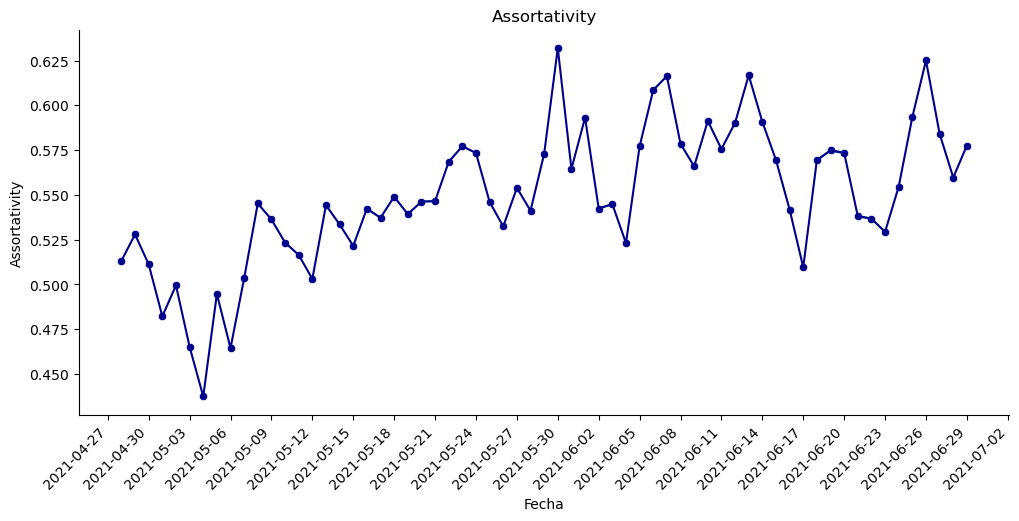

In [124]:
assortativity = pd.concat([pd.DataFrame({"Fecha": d, "assortativity_mean": descriptive_statistics[d]["assortativity_mean"], "assortativity_variance": descriptive_statistics[d]["assortativity_variance"], "N": descriptive_statistics[d]["n_nodes"]}, index = [0]) for d in descriptive_statistics.keys()])
assortativity["Fecha"] = pd.to_datetime(assortativity["Fecha"])
assortativity["assortativity_low"] = assortativity["assortativity_mean"] - 1.96*np.sqrt(assortativity["assortativity_variance"])/np.sqrt(assortativity["N"])
assortativity["assortativity_high"] = assortativity["assortativity_mean"] + 1.96*np.sqrt(assortativity["assortativity_variance"])/np.sqrt(assortativity["N"])

fig, ax = plt.subplots(figsize = (12, 5))
sns.despine()
plt.title("Assortativity")
sns.lineplot(data = assortativity, x = "Fecha", y = "assortativity_mean", ax = ax, color = "darkblue")
sns.scatterplot(data = assortativity, x = "Fecha", y = "assortativity_mean", ax = ax, color = "darkblue")
# El IC es MUY pequeño porque N es MUY grande
ax.fill_between(assortativity["Fecha"], assortativity["assortativity_low"], assortativity["assortativity_high"])
plt.xlabel("Fecha");
plt.ylabel("Assortativity")
plt.xticks(rotation = 45, ha = 'right');
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))

- **Homophily Index:** refers to the tendency of individuals (or nodes in a network) to associate and bond with similar others. The similarity can be based on various attributes such as social characteristics, behaviors, or beliefs. In the context of a network, this implies that nodes are more likely to form connections with other nodes that belong to the same group or share similar attributes. 

    Measuring Homophily. We begin with some simple definitions that are important in measuring homophily and also in presenting the model.

    Let $ N $ denote the number of type $ i $ individuals in the population, and let $ w_i = \frac{N_i}{N} $ be the relative fraction of type $ i $ in the population, where $ N = \sum_k N_k $.

    Let $ s_i $ denote the average number of friendships that agents of type $ i $ have with agents who are of the same type, and let $ d_i $ be the average number of friendships that type $ i $ agents form with agents of types different from $ i $. Let $ t_i = s_i + d_i $ be the average total number of friendships that type $ i $ agents form.

    The homophily index $ H_i $ measures the fraction of the ties of individuals of type $ i $ that are with that same type.

    **Definition 1** The homophily index $ H_i $ is defined by

    $$ H_i = \frac{s_i}{s_i + d_i} $$

    The profile $ (s, d) $ exhibits *baseline homophily* for type $ i $ if $ H_i = w_i $.

    The profile $ (s, d) $ exhibits *inbreeding homophily* for type $ i $ if $ H_i > w_i $.

    Generally, there is a difficulty in simply measuring homophily according to $ H_i $. For example, consider a group that comprises 95% of a population. Suppose that its same-type friendships are 95% of its friendships. Compare this to a group that comprises 5% of a population and has 96% of its friendships being same-type. Although both have the same homophily index, they are very different in terms of how homophilous they are relative to how homophilous they could be. Comparing the homophily index, $ H_i $, to the baseline, $ w_i $, provides some information, but even that does not fully capture the idea of how biased a group is compared to how biased it could potentially be. To take care of this we use the inbreeding homophily index introduced by Coleman [Coleman J. (1958) *Human Organization* 17:28–36] that normalizes the homophily index by the potential extent to which a group could be biased.

    **Definition 2** Coleman's inbreeding homophily index of type $i$ is

    $$IH_i = \frac{H_i - w_i}{1 - w_i}$$

    This index measures the amount of bias with respect to baseline homophily as it relates to the maximum possible bias (the term $ 1 - w_i $). It can be easily checked that we have inbreeding homophily for type $ i $ if and only if $ IH_i > 0 $, and inbreeding heterophily for type $ i $ if and only if $ IH_i < 0 $. The index of inbreeding homophily is 0 if there is pure baseline homophily, and 1 if a group completely inbreeds.


In [169]:
def homophily_index(graph, property_name):
    prop_map = graph.vp[property_name]

    # Extraigamos las categorías disponibles
    labels = [prop_map[v] for v in graph.vertices()]
    categorias = np.unique(labels)
    # Contemos cuantos nodos tenemos
    N = len(labels)

    # Extraigamos todos los tipos de enlaces
    edges_data = []
    for e in graph.edges():
        source_type = prop_map[e.source()]
        target_type = prop_map[e.target()]
        edges_data.append((source_type, target_type))

    enlaces = pd.DataFrame(edges_data, columns = ["Source", "Target"])


    w_i = dict()
    s_i = dict()
    d_i = dict()
    H_i = dict()
    IH_i = dict()
    for c in categorias:
        # Calculate w_i
        w_i[c] = labels.count(c)/N
        # Calculate s_i and d_i 
        s_i[c] = enlaces[(enlaces["Source"] == c) & (enlaces["Target"] == c)].shape[0]/enlaces.shape[0]
        d_i[c] = enlaces[(enlaces["Source"] == c) & (enlaces["Target"] != c)].shape[0]/enlaces.shape[0]
        # Calculate Homophily index
        H_i[c] = s_i[c]/(s_i[c] + d_i[c])
        # Calculate Coleman's inbreeding Homophily Index
        IH_i[c] = (H_i[c] - w_i[c])/(1 - w_i[c])

    return {"w_i": w_i, "s_i": s_i, "d_i": d_i, "H_i": H_i, "IH_i": IH_i}

In [176]:
H = pd.DataFrame()
IH = pd.DataFrame()

for file in tqdm(files):
    # Get date
    date = file.split('/')[-1].split('.')[0]
    g = gt.load_graph(file)

    hi = homophily_index(graph = g, property_name = "Label")
    temp = pd.DataFrame(hi["H_i"], index = [0])
    H = pd.concat([H, temp], axis = 0)
    temp = pd.DataFrame(hi["IH_i"], index = [0])
    IH = pd.concat([IH, temp], axis = 0)

H = pd.concat([assortativity["Fecha"], H], axis = 1).reset_index(drop = True)
IH = pd.concat([assortativity["Fecha"], IH], axis = 1).reset_index(drop = True)

H = H.melt(id_vars = "Fecha", var_name = "Ideología", value_name = "Homophily")
IH = IH.melt(id_vars = "Fecha", var_name = "Ideología", value_name = "Homophily")

100%|██████████| 63/63 [01:15<00:00,  1.20s/it]


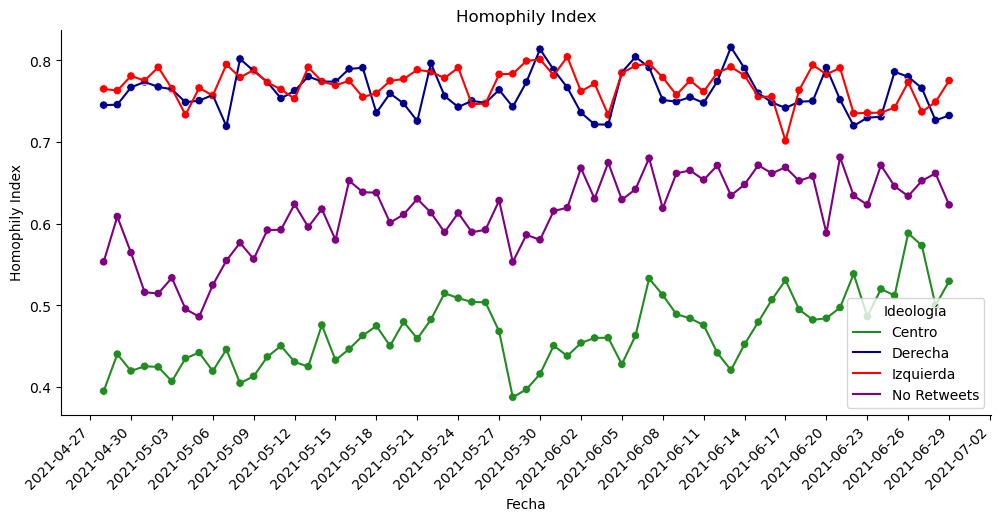

In [189]:
fig, ax = plt.subplots(figsize = (12, 5))
sns.despine()
plt.title("Homophily Index")
sns.lineplot(data = H, x = "Fecha", y = "Homophily", hue = "Ideología", ax = ax, palette = ["forestgreen", "darkblue", "red", "purple"])
sns.scatterplot(data = H, x = "Fecha", y = "Homophily", hue = "Ideología", ax = ax, legend = False, 
                palette = ["forestgreen", "darkblue", "red", "purple"])
plt.xlabel("Fecha");
plt.ylabel("Homophily Index")
plt.xticks(rotation = 45, ha = 'right');
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))

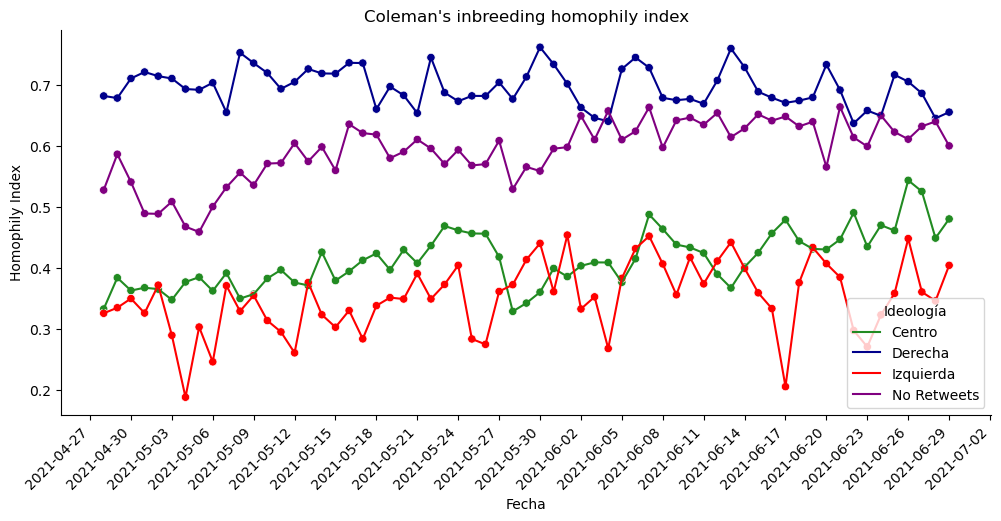

In [190]:
fig, ax = plt.subplots(figsize = (12, 5))
sns.despine()
plt.title("Coleman's inbreeding homophily index")
sns.lineplot(data = IH, x = "Fecha", y = "Homophily", hue = "Ideología", ax = ax, palette = ["forestgreen", "darkblue", "red", "purple"])
sns.scatterplot(data = IH, x = "Fecha", y = "Homophily", hue = "Ideología", ax = ax, legend = False, 
                palette = ["forestgreen", "darkblue", "red", "purple"])
plt.xlabel("Fecha");
plt.ylabel("Homophily Index")
plt.xticks(rotation = 45, ha = 'right');
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))

- **Betweenness centrality:** is a measure of centrality in a graph based on shortest paths. For every pair of vertices in a connected graph, there exists at least one shortest path between the vertices such that either the number of edges that the path passes through (for unweighted graphs) or the sum of the weights of the edges (for weighted graphs) is minimized. The betweenness centrality for each vertex is the number of these shortest paths that pass through the vertex.

- 

In [196]:
ls = []
for file in tqdm(files):
    # Get date
    date = datetime.strptime(file.split('/')[-1].split('.')[0], '%Y-%m-%d')
    g = gt.load_graph(file)
    
    # Check for edge weight property
    if "weight" in g.edge_properties:
        weight_prop = g.ep["weight"]
    else:
        weight_prop = None

    # Centrality measures
    vertex_betweenness, edge_betweenness = gt.betweenness(g, weight=weight_prop)
    ls.append([float(np.mean(edge_betweenness.a)), float(np.std(edge_betweenness.a)), date, 'Edge Betweenness'])

    pagerank_scores = gt.pagerank(g, weight=weight_prop)
    ls.append([float(np.mean(pagerank_scores.a)), float(np.std(pagerank_scores.a)), date, 'PageRank'])

    eigenvector_values, eigenvector = gt.eigenvector(g, weight=weight_prop)
    ls.append([float(np.mean(eigenvector.a)), float(np.std(eigenvector.a)), date, 'Eigenvector Centrality'])

# Create DataFrame
viz = pd.DataFrame(ls, columns = ['Value', 'Standard Deviation', 'Date', 'Statistic'])

# Convert to numeric where applicable
viz['Value'] = pd.to_numeric(viz['Value'], errors='coerce')
viz['Standard Deviation'] = pd.to_numeric(viz['Standard Deviation'], errors='coerce')

viz.head()

100%|██████████| 63/63 [03:43<00:00,  3.55s/it]


,Value,Standard Deviation,Date,Statistic
0,0.000006,0.000076,2021-04-28,Edge Betweenness
1,0.000042,0.000372,2021-04-28,PageRank
2,0.000042,0.006464,2021-04-28,Eigenvector Centrality
3,0.000006,0.000081,2021-04-29,Edge Betweenness
4,0.000047,0.000406,2021-04-29,PageRank


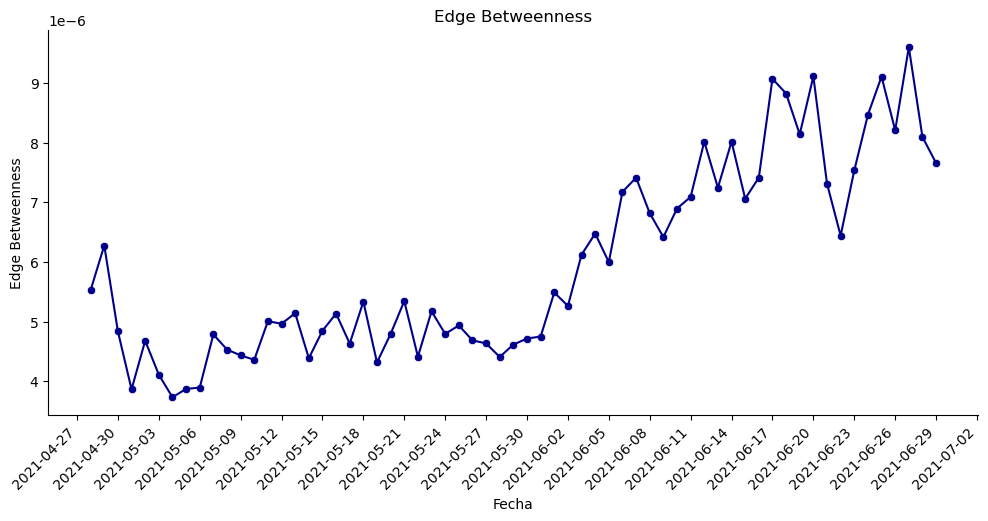

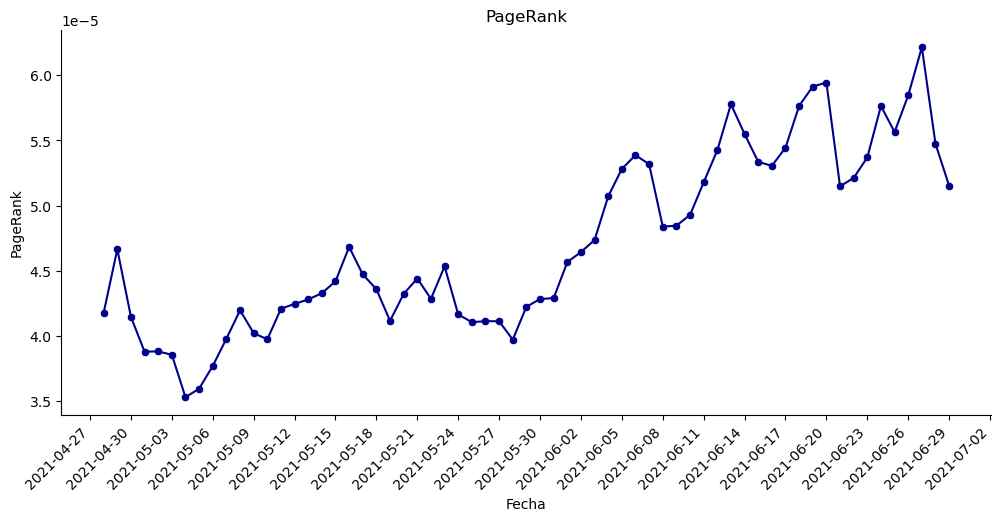

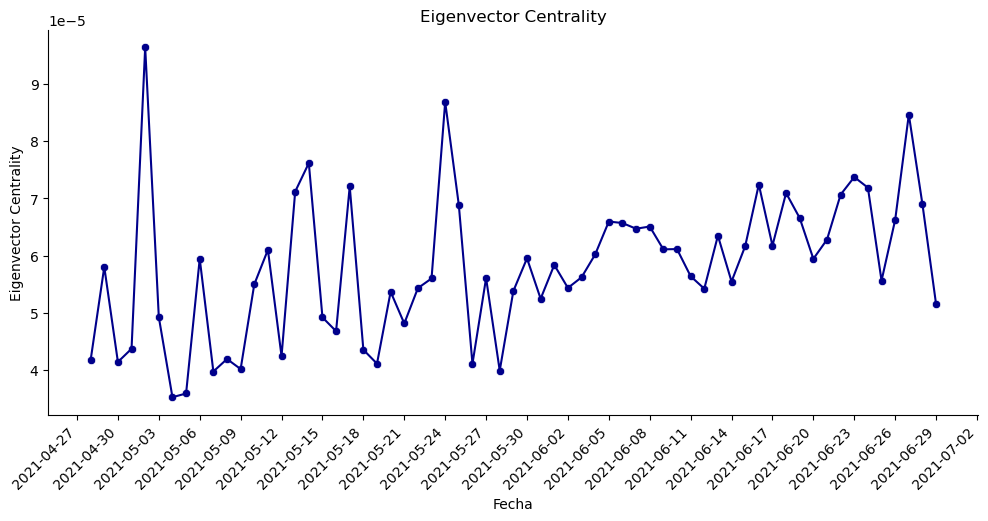

In [193]:
for i in viz["Statistic"].unique():
    fig, ax = plt.subplots(figsize = (12, 5))
    sns.despine()
    sns.lineplot(data = viz.query(f"Statistic == '{i}'"), x = "Date", y = "Value", ax = ax, color = "darkblue")
    sns.scatterplot(data = viz.query(f"Statistic == '{i}'"), x = "Date", y = "Value", ax = ax, color = "darkblue")
    plt.title(i)
    plt.ylabel(i)
    plt.xlabel("Fecha")
    plt.xticks(rotation = 45, ha = 'right');
    ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))